In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import scanpy as sc
import logging
import argparse
from datetime import datetime 
import json
import anndata as ad
from scipy.sparse import csr_matrix
import scanpy.external as sce
from sklearn.metrics.pairwise import cosine_similarity

# Description 

In this notebook, we perform a fine annotation of the anno_data.h5ad generated in 3_anno_alldata.ipynb 

## non neuron fine annotation  


perform a higer resolution leiden clustering on the potentional mixing cluster, until get a clean annotation 

In [3]:
scdata = sc.read_h5ad('../anno_data/anno_data.h5ad')
scdata

AnnData object with n_obs × n_vars = 339043 × 3000
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'samples_colors', 'species_colors', 'tissues_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'harmony_0', 'umap_0'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

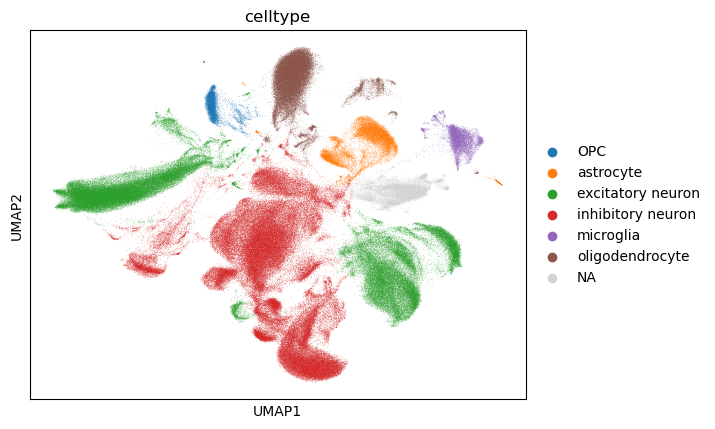

In [4]:
sc.pl.umap(scdata, color = 'celltype')

In [9]:
scdata.obs.celltype.unique()

['inhibitory neuron', 'excitatory neuron', 'astrocyte', 'oligodendrocyte', NaN, 'OPC', 'microglia']
Categories (6, object): ['OPC', 'astrocyte', 'excitatory neuron', 'inhibitory neuron', 'microglia', 'oligodendrocyte']

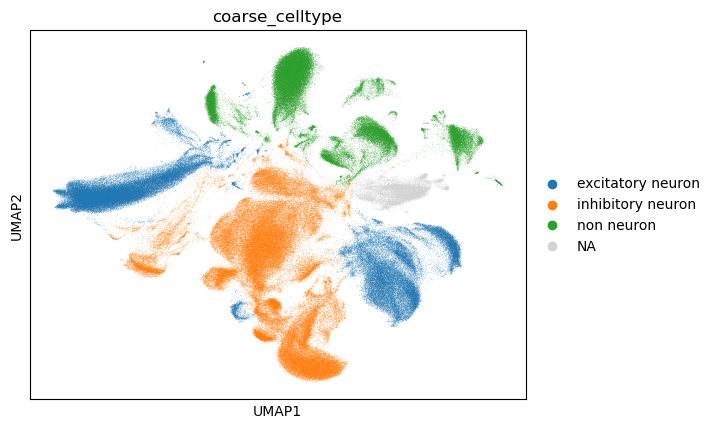

In [10]:
coarse_dic = {}
coarse_dic['excitatory neuron'] = 'excitatory neuron'
coarse_dic['inhibitory neuron'] = 'inhibitory neuron'
for key in ['OPC', 'astrocyte', 'microglia', 'oligodendrocyte']:
    coarse_dic[key] = 'non neuron'
scdata.obs.loc[:,'coarse_celltype'] = scdata.obs.celltype.map(coarse_dic)

sc.pl.umap(scdata, color = 'coarse_celltype')

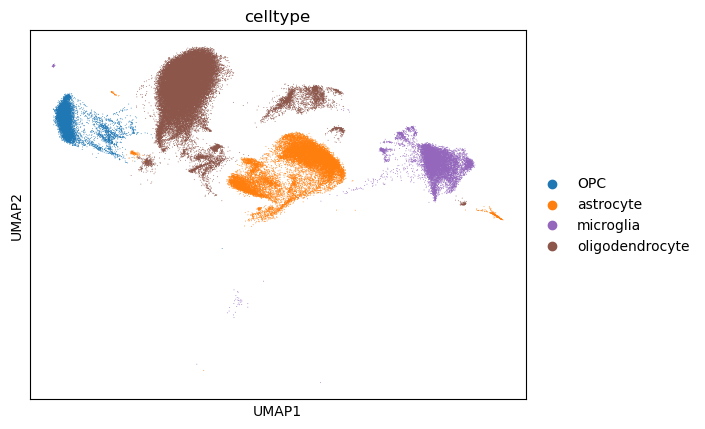

In [11]:
nndata = scdata[scdata.obs.coarse_celltype == 'non neuron']
sc.pl.umap(nndata, color = 'celltype')

/tmp/ipykernel_3882560/3120538699.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(nndata, resolution = 0.2)
/home/sunrui/anaconda3/envs/sc_gbdt/lib/python3.9/site-packages/scanpy/tools/_leiden.py:199: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


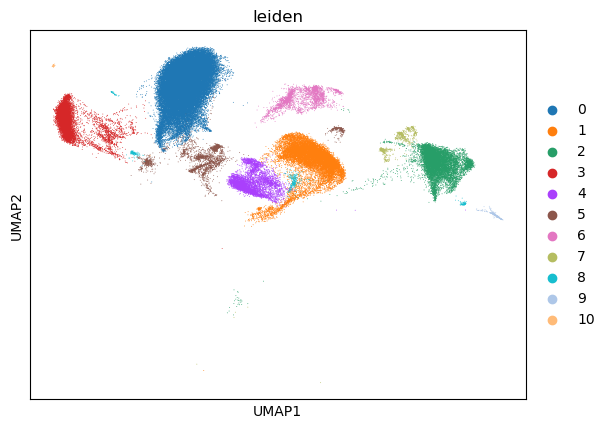

In [12]:
sc.tl.leiden(nndata, resolution = 0.2)
sc.pl.umap(nndata, color = 'leiden')

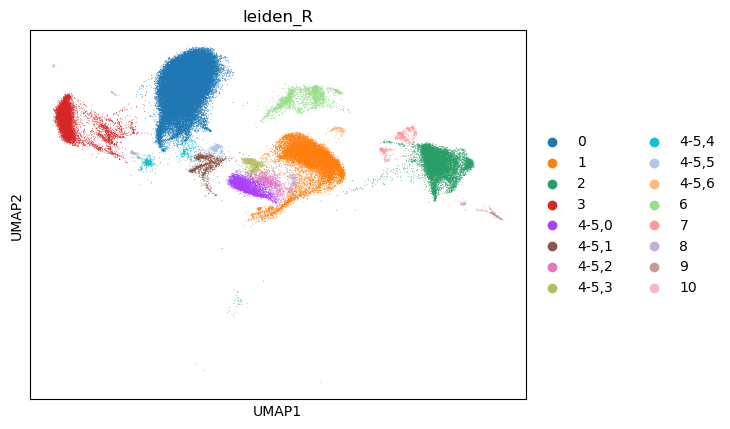

In [13]:
sc.tl.leiden(nndata, restrict_to = ('leiden',['4','5']), resolution = 0.2)
sc.pl.umap(nndata, color = 'leiden_R')

In [ ]:
ori_marker_dic = {
    'neuron': ['Snap25','Map2'],
    #'excitatory neuron': ['Arpp21','Slc17a7','Vglut1', 'Vglut2','Tbr1','Neun','Foxa2'],
    #'excitatory neuron': ['Slc17a7'],
    #'inhibitory neuron': ['Gad1','Gad2'],
    'oligodendrocyte': ['Mobp','Mog','Mbp'],
    'OPC': ['Pdgfra'],
    'astrocyte': ['Aqp4', 'Gfap', 'Slc15a2','Slc1a2','Slc1a3'],
    'endothelial': ['Abcc9', 'Pecam1', 'Cdh5'],
    'microglia': ['Cx3cr1','Csf1r','Cd53'],
    'ependymal': ['Spef2']
}



marker_dic = {}
for key in ori_marker_dic:
    tmp = []
    for ele in ori_marker_dic[key]:
        if ele in scdata.raw.var.index.values:
            tmp.append(ele)
    if len(tmp) >= 1:
        marker_dic[key] = tmp
print(marker_dic)

all_marker = []
for _ in marker_dic.values():
    all_marker += _

sc.pl.umap(nndata, color = all_marker)

{'neuron': ['Snap25', 'Map2'], 'oligodendrocyte': ['Mobp', 'Mog'], 'OPC': ['Pdgfra'], 'astrocyte': ['Slc15a2', 'Slc1a3'], 'endothelial': ['Abcc9', 'Pecam1', 'Cdh5'], 'microglia': ['Cx3cr1', 'Csf1r', 'Cd53'], 'ependymal': ['Spef2']}


In [ ]:
#marker_dic.pop('neuron')
sc.pl.dotplot(nndata, var_names = marker_dic,groupby = 'leiden_R', cmap = 'Reds')

In [ ]:
anno_dic = {}

for i in ['0','4-5,1','4-5,4','4-5,5','6']:
    anno_dic[i] = 'oligodendrocyte'
for i in [3]:
    anno_dic[str(i)] = 'OPC'
for i in ['1','4-5,6','4-5,3']:
    anno_dic[i] = 'astrocyte'
for i in ['2','7','9','10']:
    anno_dic[i] = 'microglia'
for i in ['4-5,0', '4-5,2']:
    anno_dic[i] = 'ependymal'
for i in ['8']:
    anno_dic[i] = '8'
nndata.obs.loc[:,'cluster'] = nndata.obs.leiden_R.map(anno_dic)
sc.pl.umap(nndata, color = ['leiden_R','cluster'])

In [ ]:
sc.tl.leiden(nndata, restrict_to = ('cluster',['8']), resolution = 0.2)
sc.pl.umap(nndata, color = 'leiden_R')

In [ ]:
#marker_dic.pop('neuron')
sc.pl.dotplot(nndata, var_names = marker_dic,groupby = 'leiden_R', cmap = 'Reds')

In [ ]:
anno_dic = {}

for i in ['8,3']:
    anno_dic[i] = 'microglia'
for i in ['8,0']:
    anno_dic[i] = 'astrocyte'

for i in ['astrocyte', 'OPC', 'ependymal','microglia', 'oligodendrocyte']:
    anno_dic[i] = i
nndata.obs.loc[:,'cluster'] = nndata.obs.leiden_R.map(anno_dic)
sc.pl.umap(nndata, color = ['leiden_R','cluster'])

In [ ]:
celltype = scdata.obs.celltype
celltype = celltype.astype(object)

nn_id = nndata.obs.index
celltype[nn_id] = nndata.obs.cluster.values

scdata.obs.loc[:,'celltype'] = celltype
sc.pl.umap(scdata, color = 'celltype')

## neuron fine annotation 

annotate the unknown neuron subtypes based on its DEG.

In [ ]:
subdata = scdata[scdata.obs.coarse_celltype != 'non neuron']
sc.pl.umap(subdata, color = ['celltype'])

In [ ]:
subdata.obs.celltype = subdata.obs.celltype.values.astype(object)
subdata.obs.celltype[subdata.obs.celltype.isna()] = 'unknown'

In [ ]:
sc.tl.rank_genes_groups(subdata, groupby = 'celltype', method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(subdata, groupby = 'celltype')


In [ ]:
marker_info = pd.DataFrame(subdata.uns['rank_genes_groups']['names'])
marker_info

In [ ]:
unknown_marker = marker_info.loc[:,'unknown'][:50]

sc.pl.dotplot(subdata, var_names = unknown_marker,groupby = 'celltype', cmap = 'Reds')




In [ ]:
sc.tl.leiden(subdata, resolution = 0.3)
sc.pl.umap(subdata, color = ['celltype', 'Pomc'])

In [101]:
#sc.tl.dendrogram(subdata, groupby = 'leiden', use_rep = 'X_pca_harmony')
#sc.pl.dendrogram(subdata, groupby = 'leiden')

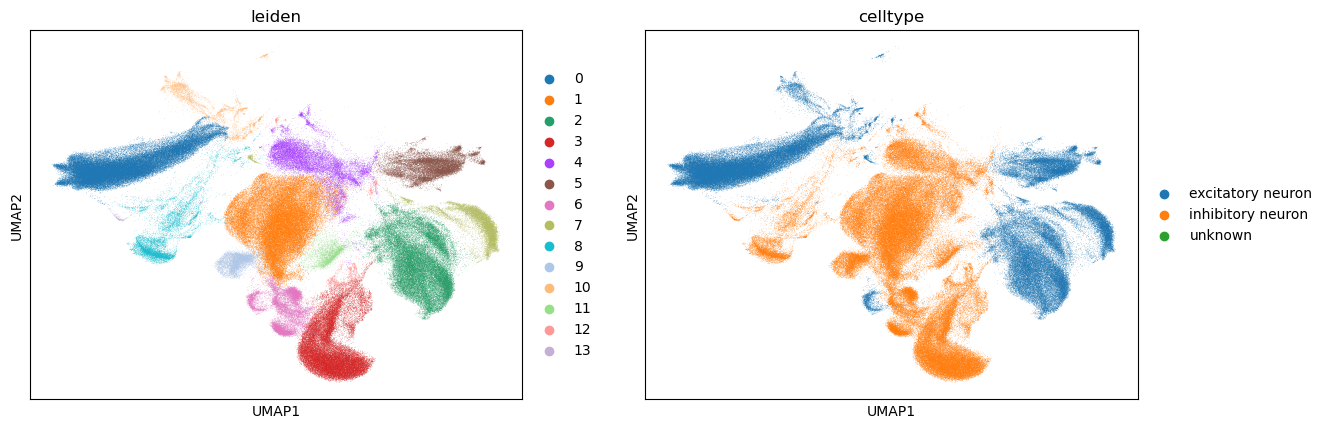

In [107]:
subdata.obs.loc[subdata.obs.celltype == 'unknown', 'celltype'] = 'excitatory neuron'
sc.pl.umap(subdata, color = ['leiden', 'celltype'])

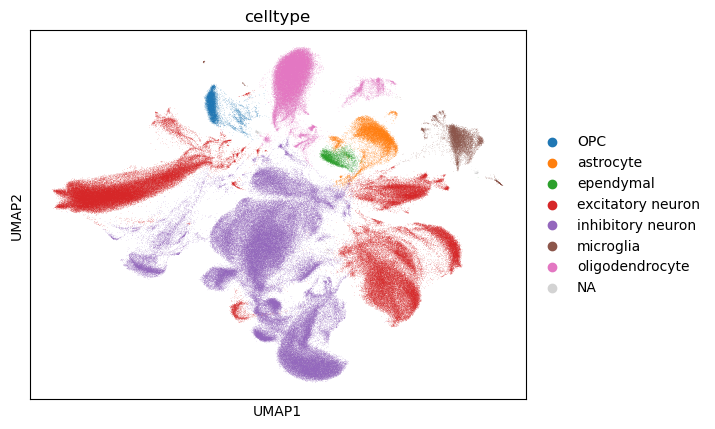

In [116]:
celltype = scdata.obs.celltype
celltype = celltype.astype(object)

neuron_id = subdata.obs.index
celltype[neuron_id] = subdata.obs.celltype.values

scdata.obs.loc[:,'celltype'] = celltype
sc.pl.umap(scdata, color = 'celltype')

## filter cells with unknown annotation 

a small amount of non-neuron cells has unknown annotation, we filter these cells.

cell number: 339043 --> 338818

(338818, 3000)


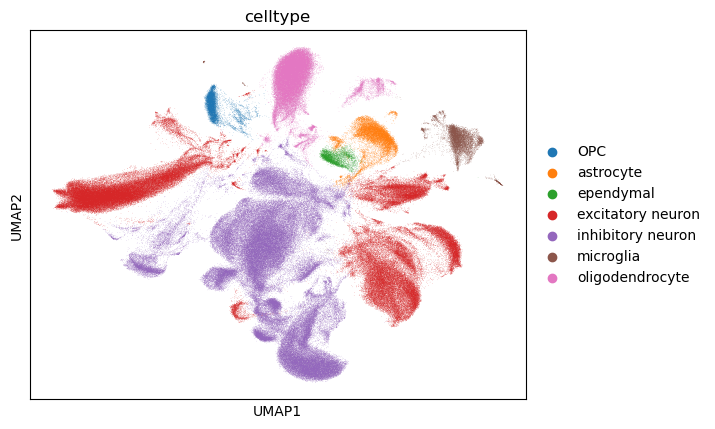

In [121]:
scdata = scdata[~scdata.obs.celltype.isna().values]
print(scdata.shape)
sc.pl.umap(scdata, color = 'celltype')

## save the annotated data 

save the fine annotation in 'celltype' column 
save the data into fine_anno.h5ad

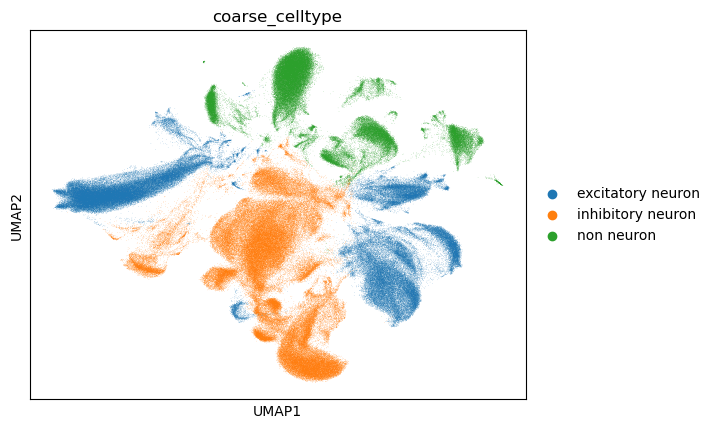

In [138]:
coarse_dic = {}
coarse_dic['excitatory neuron'] = 'excitatory neuron'
coarse_dic['inhibitory neuron'] = 'inhibitory neuron'
for key in ['OPC', 'astrocyte', 'microglia', 'oligodendrocyte', 'ependymal']:
    coarse_dic[key] = 'non neuron'
scdata.obs.loc[:,'coarse_celltype'] = scdata.obs.celltype.map(coarse_dic)


scdata.obs.loc[:,'coarse_celltype'] = scdata.obs.celltype.map(coarse_dic)

sc.pl.umap(scdata, color = 'coarse_celltype')

In [139]:
scdata.write_h5ad('final_anno.h5ad')

{'neuron': ['Snap25', 'Map2'], 'excitatory neuron': ['Slc17a8', 'Slc17a7', 'Pomc'], 'inhibitory neuron': ['Gad1', 'Gad2'], 'oligodendrocyte': ['Mobp', 'Mog'], 'OPC': ['Pdgfra'], 'astrocyte': ['Slc15a2', 'Slc1a3'], 'endothelial': ['Abcc9', 'Pecam1', 'Cdh5'], 'microglia': ['Cx3cr1', 'Csf1r', 'Cd53'], 'ependymal': ['Spef2']}


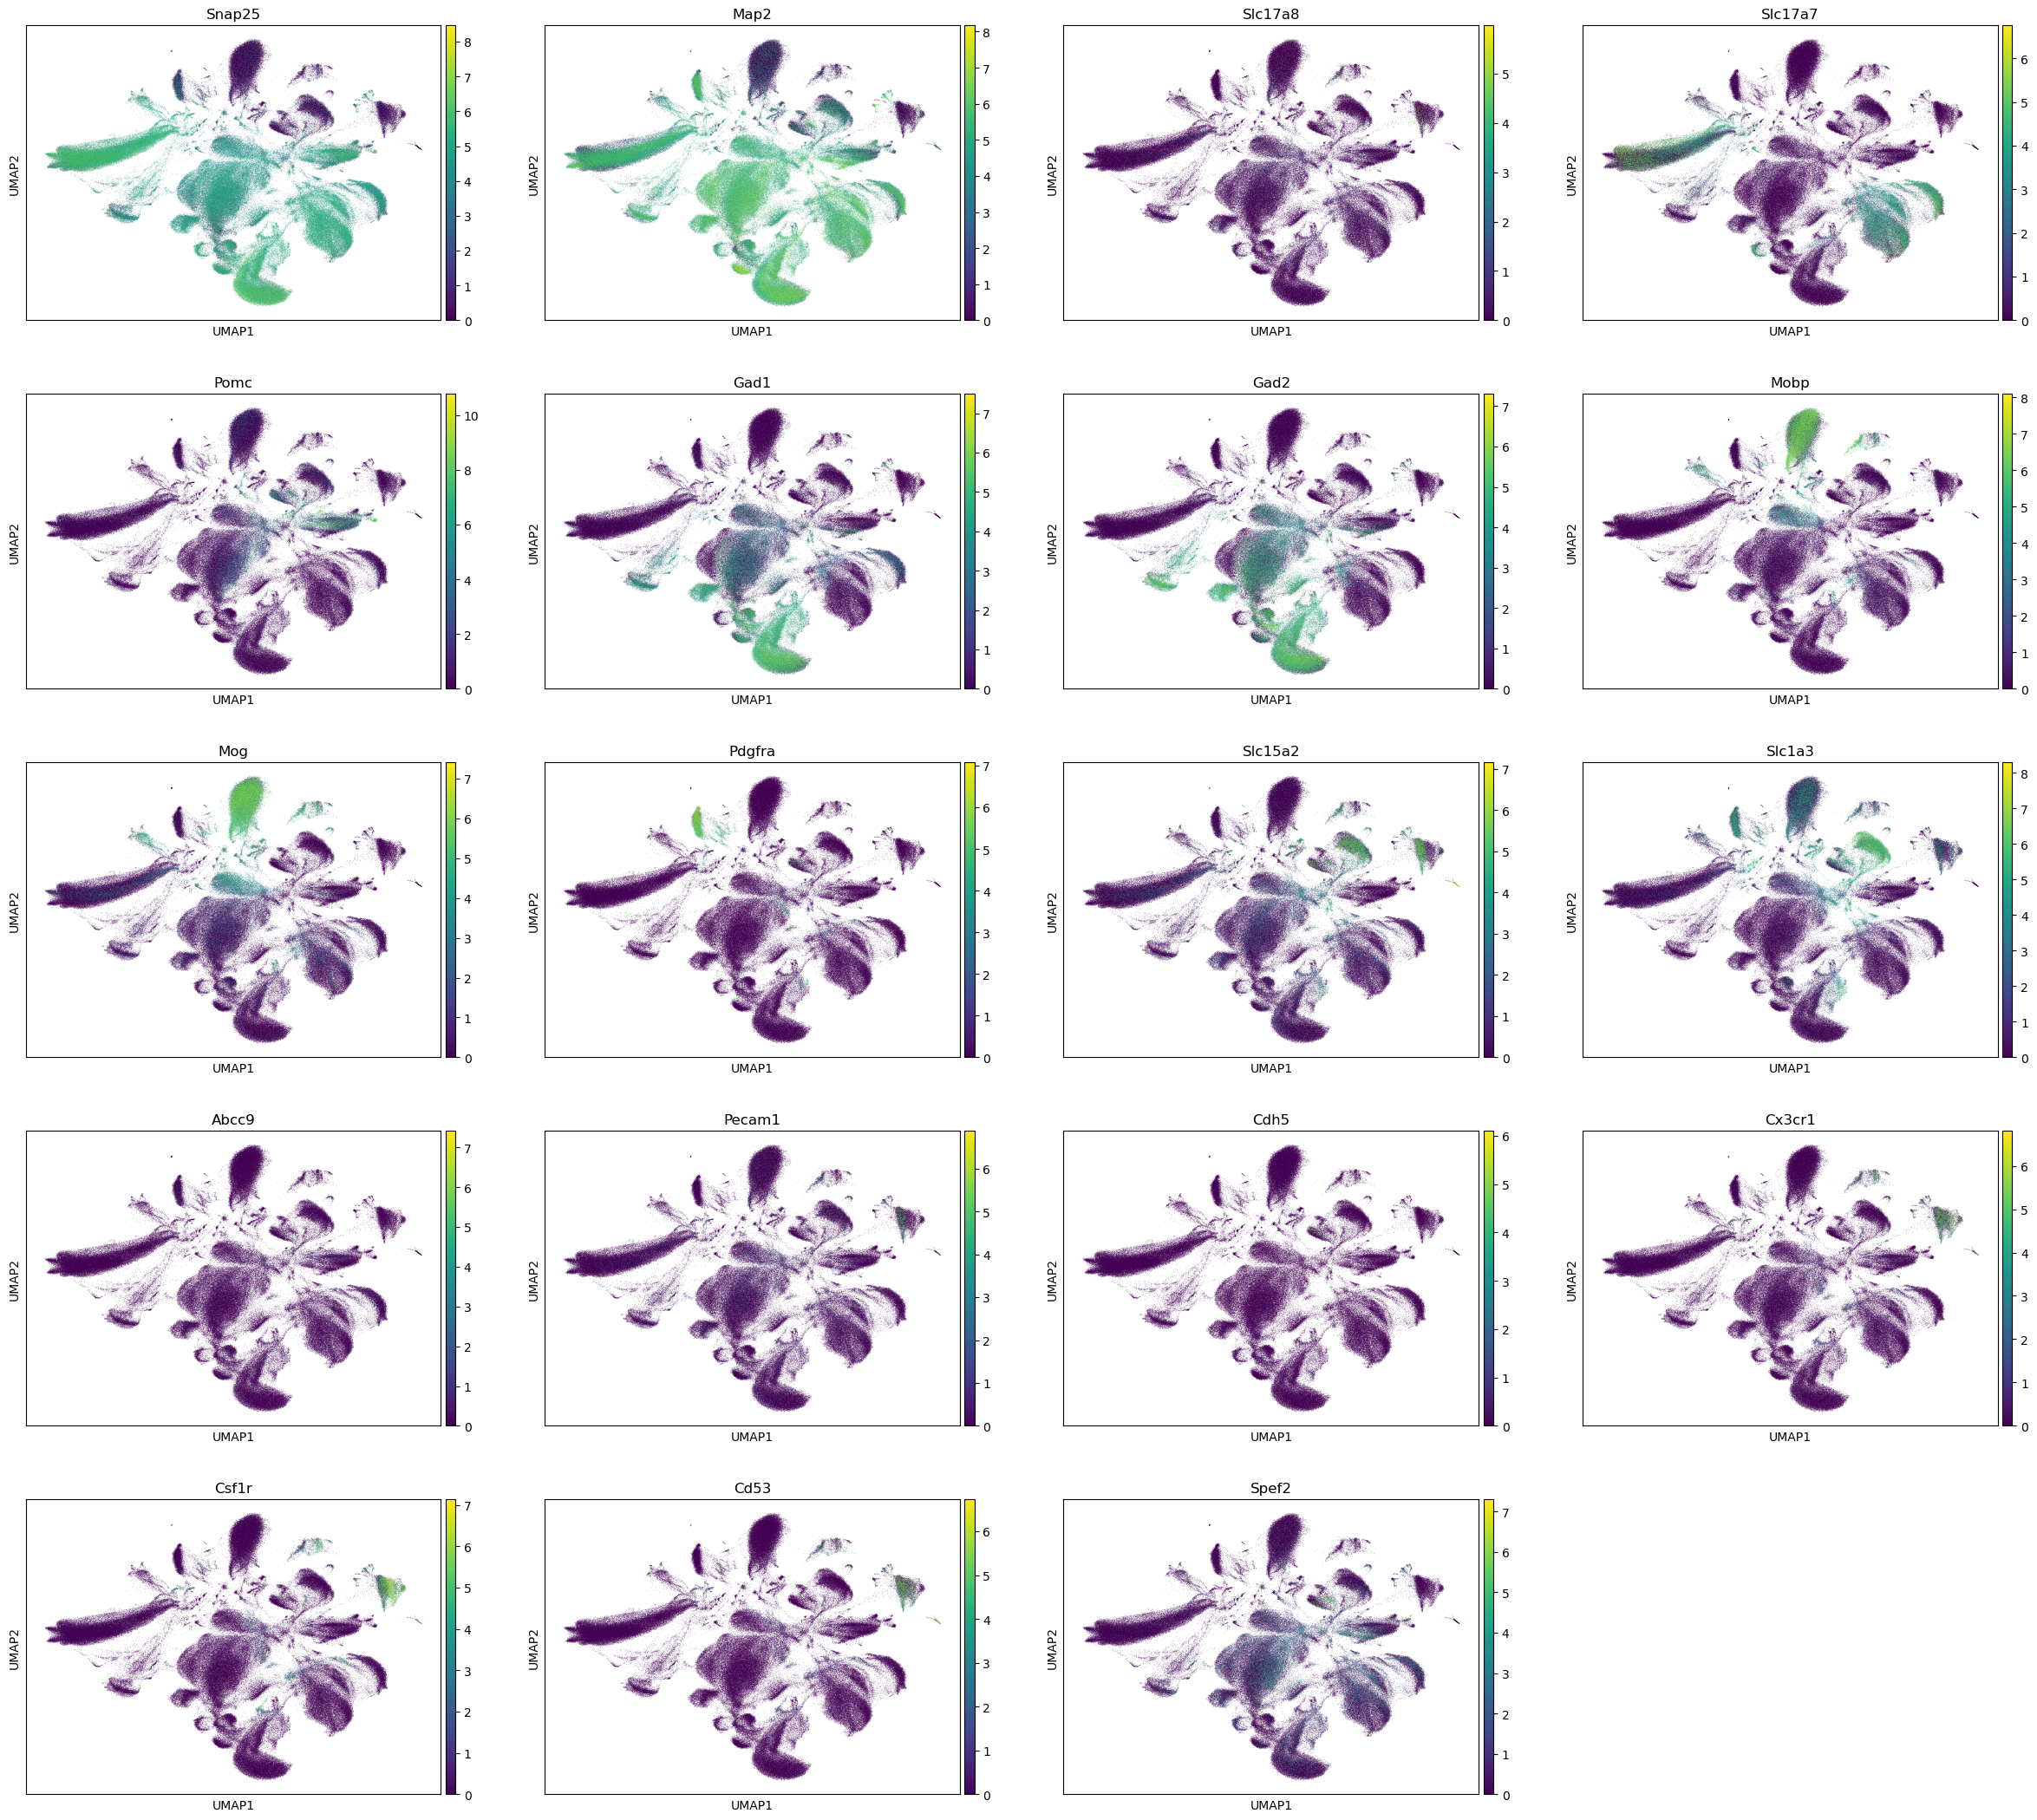

In [130]:
ori_marker_dic = {
    'neuron': ['Snap25','Map2'],
    'excitatory neuron': ['Slc17a8','Slc17a7','Pomc','Slc17a6'],
    'inhibitory neuron': ['Gad1','Gad2'],
    'oligodendrocyte': ['Mobp','Mog','Mbp'],
    'OPC': ['Pdgfra'],
    'astrocyte': ['Aqp4', 'Gfap', 'Slc15a2','Slc1a2','Slc1a3'],
    'endothelial': ['Abcc9', 'Pecam1', 'Cdh5'],
    'microglia': ['Cx3cr1','Csf1r','Cd53'],
    'ependymal': ['Spef2']
}



marker_dic = {}
for key in ori_marker_dic:
    tmp = []
    for ele in ori_marker_dic[key]:
        if ele in scdata.raw.var.index.values:
            tmp.append(ele)
    if len(tmp) >= 1:
        marker_dic[key] = tmp
print(marker_dic)

all_marker = []
for _ in marker_dic.values():
    all_marker += _

sc.pl.umap(scdata, color = all_marker)

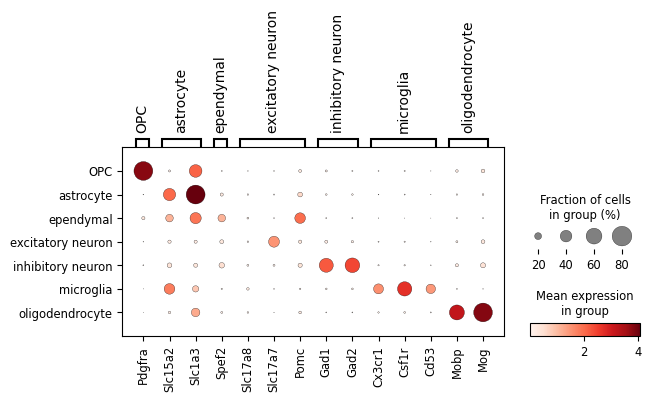

In [131]:
#marker_dic.pop('neuron')
orderd_dic = {}
for _ in scdata.obs.celltype.unique().categories.values:
    orderd_dic[_] = marker_dic[_]

sc.pl.dotplot(scdata, var_names = orderd_dic,groupby = 'celltype', cmap = 'Reds')

## the marker we used for celltype annotation

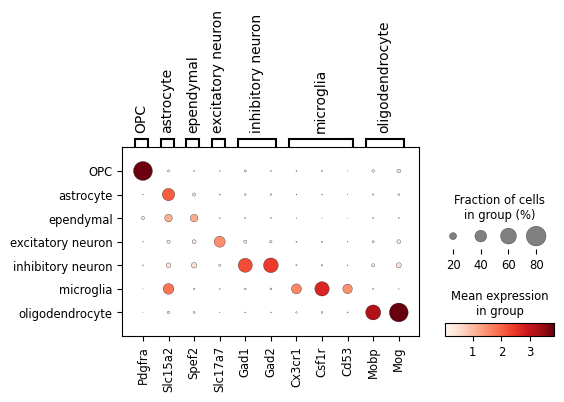

In [133]:
orderd_dic['astrocyte'] = ['Slc15a2']
orderd_dic['excitatory neuron'] = ['Slc17a7']
sc.pl.dotplot(scdata, var_names = orderd_dic,groupby = 'celltype', cmap = 'Reds')